# Global

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/MyDrive/Robotics_2/"
except:
    root_path = "./"

Mounted at /content/drive


In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView({'dataset_size': 200,
 'fps': 10,
 'samples': 100,
 'num_epochs': 1000,
 'seed': 0,
 'loss': 'baseline_nn',
 'act': 'relu_relu',
 'hidden_dim': 600,
 'output_dim': 2,
 'layers': 3,
 'n_updates': 1,
 'lr': 4e-5,
 'lr2': 2e-05,
 'dt': 0.1,
 'model': 'gln',
 'batch_size': 512,
 'l2reg': 5.7e-07,
})

# Import

In [3]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

import os, sys, time
from itertools import product
from jax.example_libraries.stax import serial, Dense, Softplus, Tanh, elementwise, Relu
import pickle as pkl
import matplotlib.pyplot as plt
from jax.tree_util import tree_flatten
from copy import deepcopy as copy

from jax.tree_util import tree_flatten
from tqdm.notebook import tqdm
import math

# Utils

In [4]:
def wrap_coords(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + jnp.pi) % (2 * jnp.pi) - jnp.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of Runge-Kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * jnp.sin(t1)
  y1 = -l1 * jnp.cos(t1)
  x2 = x1 + l2 * jnp.sin(t2)
  y2 = y1 - l2 * jnp.cos(t2)
  return x1, y1, x2, y2

def write_to(data, path):
  with open(path, 'wb') as f:
    pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

def read_from(path):
  with open(path, 'rb') as f:
    data = pkl.load(f)
  return data

def plot_loss(train_losses, test_losses):
  fig, ax = plt.subplots(1, 1)
  plt.title("Elastic Baseline loss")

  ax.plot(train_losses, label='Train loss')
  ax.plot(test_losses, label='Test loss')
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epochs")
  ax.legend()

  fig.tight_layout()

# Lagrangian Dynamics

In [5]:
def baseline_eom(baseline, state, t=None):
    q, q_t = jnp.split(state, 2)
    q = q % (2*jnp.pi)
    q_tt = baseline(q, q_t)
    return jnp.concatenate([q_t, q_tt])

# unconstrained equation of motion
def unconstrained_eom(model, state, t=None):
  q, q_t = jnp.split(state, 2)
  return model(q, q_t)

# lagrangian equation of motion
def lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  #Note: the following line assumes q is an angle. Delete it for problems other than double pendulum.
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  dt = 1e-1
  return dt*jnp.concatenate([q_t, q_tt])

def raw_lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_dynamics(dynamics_fn, initial_state, is_lagrangian=True, **kwargs):
  eom = lagrangian_eom if is_lagrangian else unconstrained_eom

  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(eom, dynamics_fn), initial_state, **kwargs)
  return f(initial_state)

def custom_init(init_params, seed=0):
  """Do an optimized LNN initialization for a simple uniform-width MLP"""
  new_params = []
  rng = jax.random.PRNGKey(seed)
  i = 0
  number_layers = len([0 for l1 in init_params if len(l1) != 0])
  for l1 in init_params:
      if (len(l1)) == 0: new_params.append(()); continue
      new_l1 = []
      for l2 in l1:
          if len(l2.shape) == 1:
              #Zero init biases
              new_l1.append(jnp.zeros_like(l2))
          else:
              n = max(l2.shape)
              first = int(i == 0)
              last = int(i == number_layers - 1)
              mid = int((i != 0) * (i != number_layers - 1))
              mid *= i

              std = 1.0/np.sqrt(n)
              std *= 2.2*first + 0.58*mid + n*last

              if std == 0:
                  raise NotImplementedError("Wrong dimensions for MLP")

              new_l1.append(jax.random.normal(rng, l2.shape)*std)
              rng += 1
              i += 1

      new_params.append(new_l1)

  return new_params

# Physics

In [6]:
@jit
def test_kinetic_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8, I=1, d1=1, Im=1):
  q, q_dot = jnp.split(state,2)
  (t1, t2), (w1, w2) = q, q_dot

  T1 = 0.5 * (I+m1*(d1**2)) * (w1**2)
  T2 = 0.5 * Im * (w2**2)
  T = T1 + T2
  return T

@jit
def test_potential_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8,d1=1,k=1):
  q, q_dot = jnp.split(state,2)
  (t1, t2), (w1, w2) = q, q_dot

  Ug = m1*g*d1*jnp.sin(t1)
  Ue = 0.5*k*((t1-t2)**2)
  V = Ug+Ue
  return V
@jit
def kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8, I=1, d1=1, Im=1):
  (t1, t2), (w1, w2) = q, q_dot

  T1 = 0.5 * (I+m1*(d1**2)) * (w1**2)
  T2 = 0.5 * Im * (w2**2)
  T = T1 + T2
  return T

@jit
def potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8,d1=1,k=1):
  (t1, t2), (w1, w2) = q, q_dot

  Ug = m1*g*d1*jnp.sin(t1)
  Ue = 0.5*k*((t1-t2)**2)
  V = Ug+Ue
  return V

# Double pendulum lagrangian
@jit
def lagrangian_fn(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
  (t1, t2), (w1, w2) = q, q_dot

  T = kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  V = potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  return T - V

# Double pendulum lagrangian
@jit
def hamiltonian_fn(q, q_dot, m1=1, m2=1, l1=0.3, l2=1, g=9.8):
  (t1, t2), (w1, w2) = q, q_dot

  T = kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  V = potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  return T + V

# Double pendulum dynamics via analytical forces taken from Diego's blog
@jit
def analytical_fn(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8,d1=1,I=1,Im=1,k=1):
  t1, t2, w1, w2 = state
  a1 = 0
  a2 = 0
  f1 = (-m1*g*d1*jnp.cos(t1)+k*(t1-t2))/(I+m1*(d1**2))
  f2 = k*(t1-t2)/Im
  g1 = f1
  g2 = f2
  return jnp.stack([w1, w2, g1, g2])

# Data

In [23]:
@partial(jax.jit, backend='cpu')
def get_trajectory(y0, times, use_lagrangian=False, **kwargs):
  # frames = int(fps*(t_span[1]-t_span[0]))
  # times = jnp.linspace(t_span[0], t_span[1], frames)
  # y0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
  if use_lagrangian:
    y = solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)
  else:
    y = odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)
  return y

@partial(jax.jit, backend='cpu')
def get_trajectory_lagrangian(y0, times, **kwargs):
  return solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_analytic(y0, times, **kwargs):
    return odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)

vfnc = jax.jit(jax.vmap(analytical_fn, 0, 0))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
venergy = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_lagrangian), (0, None), 0))

def new_get_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False,energy=False, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng, (samples, 2))*2.0*np.pi,
        jax.random.uniform(rng+1, (samples, 2))*0.1
    ], axis=1)

    if unlimited_steps:
        y = vget(y0, times)
    else:
      if energy:
        y = venergy(y0,times)
      else:
        y = vget_unlimited(y0, times)


    #This messes it up!
#     y = np.concatenate(((y[..., :2]%(2*np.pi)) - np.pi, y[..., 2:]), axis=2)

    data['x'] = y[:, :-lookahead]
    data['x'] += jax.random.uniform(rng, shape=data['x'].shape)*2.0*np.pi
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data



# Models

In [8]:
# replace the lagrangian with a parameteric model
def learned_dynamics(params):
  @jit
  def dynamics(q, q_t):
#     assert q.shape == (2,)
    state = wrap_coords(jnp.concatenate([q, q_t]))
    return nn_forward_fn(params, state)
  return dynamics

def learned_dynamics_lnn(params):
  @jit
  def dynamics(q, q_t):
#     assert q.shape == (2,)
    state = wrap_coords(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn_lnn(params, state), axis=-1)
  return dynamics

sigmoid = jit(lambda x: 1/(1+jnp.exp(-x)))
swish = jit(lambda x: x/(1+jnp.exp(-x)))
relu3 = jit(lambda x: jnp.clip(x, 0.0, float('inf'))**3)
Swish = elementwise(swish)
Relu3 = elementwise(relu3)

def extended_mlp(args):
    act = {
        'softplus': [Softplus, Softplus],
        'swish': [Swish, Swish],
        'tanh': [Tanh, Tanh],
        'tanh_relu': [Tanh, Relu],
        'soft_relu': [Softplus, Relu],
        'relu_relu': [Relu, Relu],
        'relu_relu3': [Relu, Relu3],
        'relu3_relu': [Relu3, Relu],
        'relu_tanh': [Relu, Tanh],
    }[args.act]
    hidden = args.hidden_dim
    output_dim = args.output_dim
    nlayers = args.layers

    layers = []
    layers.extend([
        Dense(hidden),
        act[0]
    ])
    for _ in range(nlayers - 1):
        layers.extend([
            Dense(hidden),
            act[1]
        ])

    layers.extend([Dense(output_dim)])

    return stax.serial(*layers)

# Loss

In [9]:
@jax.jit
def loss(params, batch, l2reg):
    state, targets = batch#_rk4
    leaves, _ = tree_flatten(params)
    l2_norm = sum(jnp.vdot(param, param) for param in leaves)
    preds = jax.vmap(
        partial(
            baseline_eom,
            learned_dynamics(params)))(state)
    return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

# Train

In [ ]:
def train(args):
  global nn_forward_fn
  model_checkpoint = root_path + "1R_elastic_vertical/" + args.loss + "_elastic_params.pkl"
  # anchor = root_path + "Elastic/Baseline/" + args.loss + "_train_backup.pkl"
  rng = jax.random.PRNGKey(args.seed)
  minibatch_per = 200
  batch = 512
  best_params = None
  best_loss = np.inf
  test_best_loss = np.inf
  init_random_params, nn_forward_fn = extended_mlp(args)
  _, init_params = init_random_params(rng+1, (-1, 4))
  rng += 1
  model = (nn_forward_fn, init_params)
  opt_init, opt_update, get_params = optimizers.adam(args.lr)
  opt_state = opt_init([[l2/200.0 for l2 in l1] for l1 in init_params])
  best_small_loss = np.inf
  (nn_forward_fn, init_params) = model
  iteration = 0
  total_epochs = args.num_epochs
  train_losses, test_losses = [], []
  lr = 4e-5 #1e-3
  final_div_factor=1e4


  @jax.jit
  def update_derivative(i, opt_state, batch, l2reg):
      params = get_params(opt_state)
      param_update = jax.grad(
              lambda *args: loss(*args)/len(batch),
              0
          )(params, batch, l2reg)
  #     param_update = normalize_param_update(param_update)
      params = get_params(opt_state)
      return opt_update(i, param_update, opt_state), params

  #OneCycleLR:
  @jax.jit
  def OneCycleLR(pct):
      #Rush it:
      start = 0.2 #0.2
      pct = pct * (1-start) + start
      high, low = lr, lr/final_div_factor

      scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2

      return low + (high - low)*scale

  @jax.jit
  def get_derivative_dataset(rng):
    # randomly sample inputs

    y0 = jnp.concatenate([
        jax.random.uniform(rng, (batch*minibatch_per, 2))*2.0*np.pi,
        (jax.random.uniform(rng+1, (batch*minibatch_per, 2))-0.5)*10*2
    ], axis=1)

    return y0, vfnc(y0)

  # @jax.jit
  # def test_get_derivative_dataset(rng):
  #   # randomly sample inputs

  #   y0 = jnp.concatenate([
  #       jax.random.uniform(rng, (batch*(minibatch_per//10), 2))*2.0*np.pi,
  #       (jax.random.uniform(rng+1, (batch*(minibatch_per//10), 2))-0.5)*10*2
  #   ], axis=1)

  #   return y0, vfnc(y0)

  opt_init, opt_update, get_params = optimizers.adam(OneCycleLR)
  opt_state = opt_init(init_params)
  bad_iterations = 0
  print(lr)

  rng = jax.random.PRNGKey(0)
  test_rng = jax.random.PRNGKey(0) + 123
  epoch = 0
  batch_data = get_derivative_dataset(rng)[0][:10], get_derivative_dataset(rng)[1][:10]
  print(batch_data[0].shape)

  loss(get_params(opt_state), batch_data, 0.0)
  opt_state, params = update_derivative(0.0, opt_state, batch_data, 0.0)


  for epoch in tqdm(range(epoch, total_epochs)):
      epoch_loss = 0.0
      test_loss = 0.0
      num_samples = 0
      test_num_samples = 0
      all_batch_data = get_derivative_dataset(rng)
      test_all_batch_data = get_derivative_dataset(test_rng+136462)

      for minibatch in range(minibatch_per):
          fraction = (epoch + minibatch/minibatch_per)/total_epochs

          batch_data = (all_batch_data[0][minibatch*batch:(minibatch+1)*batch], all_batch_data[1][minibatch*batch:(minibatch+1)*batch])
          test_batch_data = (test_all_batch_data[0][minibatch*batch:(minibatch+1)*batch], test_all_batch_data[1][minibatch*batch:(minibatch+1)*batch])

          rng += 10
          opt_state, params = update_derivative(fraction, opt_state, batch_data, 1e-6)

          cur_loss = loss(params, batch_data, 0.0)
          epoch_loss += cur_loss


          test_cur_loss = loss(params,test_batch_data,0.0)
          test_loss += test_cur_loss

          num_samples += batch
          test_num_samples += (batch-100)

      closs = epoch_loss/num_samples
      tloss = test_loss/test_num_samples
      print('epoch={} lr={} loss={} test={}'.format(
          epoch, OneCycleLR(fraction), closs, tloss)
          )

      if closs < best_loss:
          best_loss = closs
          best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

      if tloss < test_best_loss:
          test_best_loss = tloss
          best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

      train_losses.append(closs)
      test_losses.append(tloss)

  # write_to({'train' : train_losses, 'test' : test_losses},anchor)
  write_to({'params': best_params, 'args': args},model_checkpoint)

  return train_losses, test_losses, best_params

result = train(args)
plot_loss(result[0], result[1])

4e-05
(10, 4)


KeyboardInterrupt: ignored

# Test

In [24]:
lr = 4e-5 #1e-3
final_div_factor=1e4

@jax.jit
def OneCycleLR(pct):
    #Rush it:
    start = 0.2 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor

    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2

    return low + (high - low)*scale

model_checkpoint = root_path + "1R_elastic_vertical/baseline_nn_elastic_params_1000.pkl"
model_checkpoint_lnn = root_path + "1R_elastic_vertical/lnn_elastic_params_1000.pkl"
loaded_model = read_from(model_checkpoint)
loaded_model_lnn = read_from(model_checkpoint_lnn)
loaded_args = loaded_model['args']
loaded_args_lnn = loaded_model_lnn['args']
loaded_params = loaded_model['params']
loaded_params_lnn = loaded_model_lnn['params']
init_random_params, nn_forward_fn = extended_mlp(loaded_args)
init_random_params_lnn, nn_forward_fn_lnn = extended_mlp(loaded_args_lnn)
opt_init, opt_update, get_params = optimizers.adam(OneCycleLR)
opt_init_lnn, opt_update_lnn, get_params_lnn = optimizers.adam(OneCycleLR)
opt_state = opt_init(loaded_params)
opt_state_lnn = opt_init(loaded_params_lnn)

max_t = 100
new_dataset = new_get_dataset(jax.random.PRNGKey(2),
                              t_span=[0, max_t],
                              fps=10, test_split=1.0,
                              unlimited_steps=False)

t = new_dataset['x'][0, :]
tall = [jax.device_get(t)]
p = get_params(opt_state)
p_lnn = get_params_lnn(opt_state_lnn)


pred_tall = jax.device_get(odeint(
    partial(baseline_eom, learned_dynamics(p)),
    t,
    np.linspace(0, max_t, num=new_dataset['x'].shape[0])))

max_t_lnn = 10

pred_tall_lnn = jax.device_get(odeint(
    partial(raw_lagrangian_eom, learned_dynamics_lnn(p_lnn)),
    t,
    np.linspace(0, max_t_lnn, num=new_dataset['x'].shape[0])))

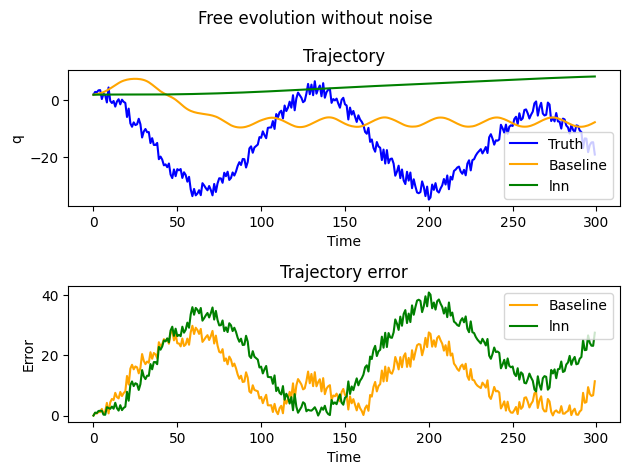

In [25]:
tall = np.array(tall)

fig, ax = plt.subplots(2, 1)
fig.suptitle("Free evolution without noise")
ax[0].set_title("Trajectory")
ax[0].plot(new_dataset['x'][:300, 0],label="Truth", color="blue")
ax[0].plot(pred_tall[:300, 0], label='Baseline', color='orange')
ax[0].plot(pred_tall_lnn[:300, 0], label='lnn', color='green')
ax[0].set_ylabel('q')
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].set_title("Trajectory error")
ax[1].plot(jnp.abs(-new_dataset['x'][:300, 0] + pred_tall[:300, 0]), label='Baseline', color='orange')
ax[1].plot(jnp.abs(-new_dataset['x'][:300, 0] + pred_tall_lnn[:300, 0]), label='lnn', color='green')
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Time')
ax[1].legend()

fig.tight_layout()

In [12]:
max_t = 10
en_new_dataset = new_get_dataset(jax.random.PRNGKey(2),
                              t_span=[0, max_t],
                              fps=10, test_split=1.0,
                              unlimited_steps=False, energy=True)
t = en_new_dataset['x'][0, :]
tall = [jax.device_get(t)]
p = get_params(opt_state)
p_lnn = get_params_lnn(opt_state_lnn)

en_pred_tall = jax.device_get(odeint(
    partial(baseline_eom, learned_dynamics(p)),
    t,
    np.linspace(0, max_t, num=en_new_dataset['x'].shape[0])))

max_t_lnn = 10

en_pred_tall_lnn = jax.device_get(odeint(
    partial(raw_lagrangian_eom, learned_dynamics_lnn(p_lnn)),
    t,
    np.linspace(0, max_t_lnn, num=en_new_dataset['x'].shape[0])))

total_true_energy = (
    jax.vmap(test_kinetic_energy,0,0)(en_new_dataset['x'][:]) + \
    jax.vmap(test_potential_energy,0,0)(en_new_dataset['x'][:])
)
total_predicted_energy = (
    jax.vmap(test_kinetic_energy,0,0)(en_pred_tall[:]) + \
    jax.vmap(test_potential_energy,0,0)(en_pred_tall[:])
)
total_predicted_energy_lnn = (
    jax.vmap(test_kinetic_energy,0,0)(en_pred_tall_lnn[:]) + \
    jax.vmap(test_potential_energy,0,0)(en_pred_tall_lnn[:])
)
scale=29.4

# translation = jnp.min(total_true_energy) + 1
# total_true_energy -= translation
# total_predicted_energy -= translation

#plt.plot(
#    (total_predicted_energy-total_true_energy)/scale
#)
plt.plot(total_true_energy)
plt.plot(total_predicted_energy)
plt.plot(total_predicted_energy_lnn)

plt.ylabel('Total Energy')
plt.xlabel('Time')


KeyboardInterrupt: ignored